<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#LGBM-model" data-toc-modified-id="LGBM-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LGBM model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter tuning</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Saving the model</a></span></li><li><span><a href="#Validation-check" data-toc-modified-id="Validation-check-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Validation check</a></span><ul class="toc-item"><li><span><a href="#Submission-XGB-SCORE" data-toc-modified-id="Submission-XGB-SCORE-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Submission XGB SCORE</a></span></li></ul></li><li><span><a href="#Misc" data-toc-modified-id="Misc-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Misc</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from lightgbm import LGBMClassifier, plot_tree #LGBMRanker
import math
import pickle
import statsmodels.api as sm


import xgboost as xgb

In [3]:
seed=1234

In [4]:
# file = open("type2id.pkl",'rb')
# object_file = pickle.load(file)

In [5]:
file_name = "otto_lgb_model_13_cv.pkl"

In [6]:
df=pd.read_parquet('train_sample_full_cv_3targets_experimental.parquet')#train_sample_full_cv_hidden_targets_float
# valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')

In [7]:
# df=df[df['MIN_TOP20']<=30]
# valid=valid[valid['MIN_TOP20']<=30]

In [8]:
# df=pd.concat([df,valid])

In [9]:
df.columns=[x.lower() for x in df.columns]
# valid.columns=[x.lower() for x in valid.columns]

In [10]:
# sessions_with_orders=pd.DataFrame(df.groupby('session_id')['target'].sum()).reset_index()
# sessions_with_orders=sessions_with_orders[sessions_with_orders['target']>0]
# df=df.merge(sessions_with_orders['session_id'], how='inner', on='session_id')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36070696 entries, 0 to 36070695
Data columns (total 51 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   target                          float64
 1   target_clicks                   float64
 2   target_carts                    float64
 3   target_orders                   float64
 4   session_id                      float64
 5   aid                             float64
 6   min_top20                       float64
 7   avg_top20                       float64
 8   max_top20                       float64
 9   in_session                      float64
 10  in_session_clicked              float64
 11  in_session_carted               float64
 12  in_session_ordered              float64
 13  in_session_score                float64
 14  in_session_score_time_weighted  float64
 15  times_in_top20                  float64
 16  times_in_top20_last_week        float64
 17  min_order_hours_from_clic

In [12]:
df.head()

,target,target_clicks,target_carts,target_orders,session_id,aid,min_top20,avg_top20,max_top20,in_session,...,number_orders,first_seen,last_seen,first_bought,last_bought,bought_overall,seen_overall,num_clicks_same_day,num_carts_same_day,num_orders_same_day
0,0.0,0.0,0.0,0.0,10096508.0,1658869.0,83.0,83.0,83.0,0.0,...,0.0,503.275254,0.267939,503.275254,82.948090,41.0,215.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,10096508.0,1662207.0,38.0,51.0,64.0,0.0,...,0.0,482.900077,102.934701,NaN,NaN,0.0,118.0,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,10096508.0,1662799.0,31.0,31.0,31.0,0.0,...,0.0,485.097319,154.847848,485.097319,179.171330,3.0,24.0,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,10096508.0,1666231.0,70.0,78.0,82.0,0.0,...,0.0,503.217558,1.789421,420.395221,35.984462,13.0,1346.0,19.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10096508.0,1672174.0,54.0,54.0,54.0,0.0,...,0.0,503.362728,2.192727,463.477754,183.506358,23.0,193.0,2.0,0.0,0.0


In [13]:
df['null_flag']=(df['avg_order_hours_from_click_avg']<99999).apply(int)
df['in_session_carted_not_ordered']=((df['in_session_carted']>0)&(df['in_session_ordered']==0)).apply(int)
df['in_session_clicked_not_carted']=((df['in_session_clicked']>0)&(df['in_session_carted']==0)).apply(int)
# valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
# valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
# valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

In [14]:
df['null_flag'].value_counts(normalize=True)

1    0.753876
0    0.246124
Name: null_flag, dtype: float64

In [15]:
df['target'].value_counts()

0.0    36031474
1.0       39222
Name: target, dtype: int64

In [16]:
#df=df[df['null_flag']==1].reset_index()
#valid=valid[valid['null_flag']==1].reset_index()

In [17]:
df['target'].value_counts()

0.0    36031474
1.0       39222
Name: target, dtype: int64

In [18]:
# rand=np.random.randint(1, 11, df.shape[0])

# train_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand<=8
# valid_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand>8

In [19]:
# df[train_mask]['target'].value_counts()

In [20]:
# df[valid_mask]['target'].value_counts()

In [21]:
col_target='target'
col_exclude=[
'session_id',
'aid',
# 'num_times_ordered_overall',
'number_carts_orders',
'number_carts',
'number_orders',
'sess_days_till_test',
'sess_dayofmonth',
# 'in_session',
# 'in_session_clicked',
# 'in_session_carted',
#  'in_session_ordered',
#  'in_session_score',
'first_seen',
'first_bought',

'target_clicks',
'target_carts',
'target_orders',
col_target,]

In [22]:
# df[col_target]=df[col_target].apply(int)

# Data exploration

In [23]:
col_preds=[col for col in df.columns[3:] if col not in col_exclude]

In [24]:
len(col_preds)

41

In [25]:
col_preds

['min_top20',
 'avg_top20',
 'max_top20',
 'in_session',
 'in_session_clicked',
 'in_session_carted',
 'in_session_ordered',
 'in_session_score',
 'in_session_score_time_weighted',
 'times_in_top20',
 'times_in_top20_last_week',
 'min_order_hours_from_click_avg',
 'avg_order_hours_from_click_avg',
 'avg_num_sessions_ordered',
 'sum_num_sessions_ordered',
 'avg_num_occured_overall',
 'sum_num_occured_overall',
 'last_num_sessions_ordered',
 'last_hour_num_sessions_ordered',
 'num_times_ordered_overall',
 'sess_num_events',
 'sess_num_clicks',
 'sess_num_carts',
 'sess_num_orders',
 'sess_num_clicks_last_hour',
 'sess_num_carts_last_hour',
 'sess_num_orders_last_hour',
 'sess_duration',
 'sess_minute',
 'sess_hour',
 'sess_dayofweek',
 'last_seen',
 'last_bought',
 'bought_overall',
 'seen_overall',
 'num_clicks_same_day',
 'num_carts_same_day',
 'num_orders_same_day',
 'null_flag',
 'in_session_carted_not_ordered',
 'in_session_clicked_not_carted']

In [26]:
# %%time
# # Basic test to identify more attractive classificator
# # Models
# import lightgbm as lgb
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn import linear_model

# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import StratifiedKFold, cross_val_score

# # Metrics
# from sklearn.metrics import roc_curve, roc_auc_score

# sample=df.sample(100000)

# # train cross validation set
# X_cv = sample[col_preds].fillna(0).reset_index(drop=True)
# y_cv =sample[col_target].reset_index(drop=True)

# BM_DATA = []
# # crossvalidation type StratifiedKFold
# SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# # fit the models from the list
# for model_name, model in [
#         ('LinearRegression', linear_model.LinearRegression()),
#         ('Ridge', linear_model.RidgeClassifier(normalize=True, random_state=seed)),
#         ('BayesianRidge', linear_model.BayesianRidge()),
#         ('Lasso', linear_model.LassoLars(random_state=seed)),
#         ('RandomForest', RandomForestClassifier(random_state=seed)),
#         ('GradientBoosting', GradientBoostingClassifier(random_state=seed)),
#         ('XGBoost', XGBClassifier(eval_metric='auc',
#                               use_label_encoder=False,
#                               random_state=seed))
         
# ]:
#     CLF_MODEL = Pipeline([(model_name, model)])
#     # Cross validation score
#     print([model_name, cross_val_score(CLF_MODEL,
#                                                 X_cv,
#                                                 y_cv,
#                                                 scoring='roc_auc',
#                                                 cv=SKF).mean()])
#     BM_DATA.append([model_name, cross_val_score(CLF_MODEL,
#                                                 X_cv,
#                                                 y_cv,
#                                                 scoring='roc_auc',
#                                                 cv=SKF).mean()])
# # Cross validation score for lgb
# BM_DATA.append(['LGBM', lgb.cv(params = {
#         'task': 'train',
#         'boosting_type': 'gbdt',
#         'objective':'binary',
#         'metric':'auc',
#         'force_row_wise':True,
#         'verbose':-1
#         }, train_set=lgb.Dataset(X_cv, y_cv), folds=SKF)['auc-mean'][-1]])

# del sample

# # Result of the models
# pd.DataFrame.from_records(BM_DATA, columns=['model', 'roc_auc']).sort_values(by='roc_auc', ascending=False).head(10)

# LGBM model

## Hyperparameter tuning

## Model fitting

In [30]:
import lightgbm as lgb

train_data = lgb.Dataset(df[col_preds], label=df[col_target])
valid_data = lgb.Dataset(df[col_preds], label=df[col_target])

parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'verbose': 0,}

parameters["num_leaves"] = int(round(9.725236104028639))
parameters['max_depth'] = int(round( 7.532898415585816))
parameters['max_bin'] = int(round(5.169796606672757))
parameters['learning_rate'] = round(0.004575693231283588,3)
parameters['feature_fraction'] = round( 0.8110328360295611,2)
parameters['bagging_fraction'] = round(0.6496238764162328,2)
parameters['subsample'] = round(0.4561955508284766,2)


xgb_model = lgb.train(parameters,
                 train_data,
                 valid_sets = valid_data, 
                 num_boost_round=500,
                 early_stopping_rounds=20)
  


[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=0.46 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=0.46 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.412251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=0.46 will be ignored. Current value: bagging_fraction=0.65
[1]	valid_0's auc: 0.92213
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.928467
[3]	valid_0's auc: 0.930293
[4]	valid_0's auc: 0.931544
[5]	valid_0's auc: 0.933784
[6]	valid_0's auc: 0.93465
[7]	valid_0's auc: 0.93534
[8]	valid_0's auc: 0.936056
[9]	valid_0's auc: 0.936428
[10]	valid_0's auc: 0.936979
[11]	valid_0's auc: 0.937423
[12]	valid_0's auc: 0.937722
[13]	valid_0's

[257]	valid_0's auc: 0.947399
[258]	valid_0's auc: 0.947408
[259]	valid_0's auc: 0.947412
[260]	valid_0's auc: 0.947419
[261]	valid_0's auc: 0.947431
[262]	valid_0's auc: 0.947437
[263]	valid_0's auc: 0.947443
[264]	valid_0's auc: 0.947453
[265]	valid_0's auc: 0.947463
[266]	valid_0's auc: 0.947469
[267]	valid_0's auc: 0.947475
[268]	valid_0's auc: 0.947485
[269]	valid_0's auc: 0.947489
[270]	valid_0's auc: 0.947497
[271]	valid_0's auc: 0.947505
[272]	valid_0's auc: 0.947514
[273]	valid_0's auc: 0.947522
[274]	valid_0's auc: 0.947528
[275]	valid_0's auc: 0.947535
[276]	valid_0's auc: 0.947544
[277]	valid_0's auc: 0.947548
[278]	valid_0's auc: 0.947554
[279]	valid_0's auc: 0.947561
[280]	valid_0's auc: 0.947568
[281]	valid_0's auc: 0.947578
[282]	valid_0's auc: 0.947585
[283]	valid_0's auc: 0.947589
[284]	valid_0's auc: 0.947595
[285]	valid_0's auc: 0.947602
[286]	valid_0's auc: 0.94761
[287]	valid_0's auc: 0.947615
[288]	valid_0's auc: 0.947624
[289]	valid_0's auc: 0.947631
[290]	valid

In [31]:
df['XGB_SCORE']=xgb_model.predict(df[col_preds])
# train['XGB_SCORE']=xgb_model.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE']=xgb_model.predict(valid[col_preds])

In [32]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 8.600182092231103
The gini on the train set is: 0.8984742309898339


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

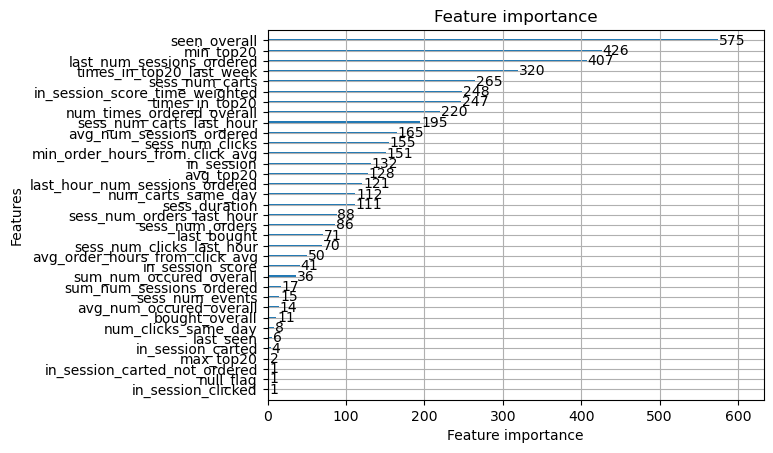

In [33]:
lgb.plot_importance(xgb_model)

# Saving the model

In [34]:
#file_name = "otto_xgb_model_10_3weeks_no_nulls.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

# Validation check

In [35]:
del df
# del train

In [36]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math
import pickle


import xgboost as xgb

In [37]:
# file_name = "otto_xgb_model_12_cv_571.pkl"

# #load
# xgb_model= pickle.load(open(file_name, "rb"))

In [38]:
col_target='target'

In [39]:
valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')
valid.columns=[x.lower() for x in valid.columns]
valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)
valid['XGB_SCORE']=xgb_model.predict(valid[xgb_model.feature_name()])

In [40]:
result=[]
for i in [100,90,80,70,60,50,40,30]:
    valid_=valid[valid['min_top20']<=i]
    gini=mofr.metrics.gini(valid_[col_target], valid_['XGB_SCORE'])
    a=valid_[['session_id', 'aid', 'XGB_SCORE',col_target]].groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
    num_captured=np.sum(a[col_target])
    print (i,gini, num_captured)
    result.append((i,gini, num_captured))
    
pd.DataFrame(result)

100 0.9115960172974613 32152.0
90 0.9109290831476717 32143.0
80 0.9101387923580773 32141.0
70 0.9089343161628893 32131.0
60 0.9078925635213553 32139.0
50 0.9056110391723964 32142.0
40 0.9024259039039622 32131.0
30 0.8995606604100574 32117.0


,0,1,2
0,100,0.911596,32152.0
1,90,0.910929,32143.0
2,80,0.910139,32141.0
3,70,0.908934,32131.0
4,60,0.907893,32139.0
5,50,0.905611,32142.0
6,40,0.902426,32131.0
7,30,0.899561,32117.0


In [41]:
valid.head()

,target,target_clicks,target_carts,target_orders,session_id,aid,min_top20,avg_top20,max_top20,in_session,...,last_bought,bought_overall,seen_overall,num_clicks_same_day,num_carts_same_day,num_orders_same_day,null_flag,in_session_carted_not_ordered,in_session_clicked_not_carted,XGB_SCORE
0,0.0,0.0,0.0,0.0,11098546.0,605.0,9.0,50.000000,91.0,0.0,...,5.625833,255.0,3004.0,9.0,1.0,1.0,1,0,0,0.152916
1,0.0,0.0,0.0,0.0,11098546.0,665.0,71.0,71.000000,71.0,0.0,...,171.533104,3.0,31.0,1.0,0.0,0.0,0,0,0,0.032125
2,0.0,0.0,0.0,0.0,11098546.0,1089.0,16.0,45.666667,82.0,0.0,...,1.657222,864.0,15026.0,127.0,1.0,0.0,1,0,0,0.099905
3,0.0,0.0,0.0,0.0,11098546.0,1303.0,35.0,60.500000,87.0,0.0,...,28.698889,464.0,4974.0,32.0,5.0,0.0,1,0,0,0.060689
4,0.0,0.0,0.0,0.0,11098546.0,1398.0,15.0,15.000000,15.0,0.0,...,NaN,0.0,11.0,NaN,NaN,NaN,0,0,0,0.183634


In [42]:
valid[col_target].value_counts()

0.0    28769561
1.0       38983
Name: target, dtype: int64

In [43]:
# coverage=(pd.DataFrame(df.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(df.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the train set is: {target_coverage}')
# print(f'The mean coverage of carts on the train set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the train set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

In [44]:
# coverage=(pd.DataFrame(valid.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(valid.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the valid set is: {target_coverage}')
# print(f'The mean coverage of carts on the valid set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the valid set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

## Submission XGB SCORE

In [45]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [46]:
# a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['in_session','times_in_top20','XGB_SCORE'], ascending = [False,False,False]).head(20).reset_index(drop = True)).reset_index(drop = True)
# a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
# a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
# pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [47]:
# TOP CLICKS AND ORDERS IN TEST
top_clicks = ['485256', '1460571','108125','1551213','33343','613493','876493','152547','184976','1236775'
              ,'1406660','836852','331708','1531805','29735','554660','634452','986164','959208','832192']

top_carts = ['485256', '33343','613493','152547','876493','1406660','1736857','166037','1460571','1236775'
             ,'554660','660655','1531805','1022566','231487','122983','1562705','923948','332654','544144']

top_orders = ['876493', '1406660','1236775','166037','1460571','1531805','836852','634452','923948','1043508'
             ,'832192','258353','801774','332654','1596897','29735','544144','1581568','1462420','1006198']

In [48]:
submission_clicks_valid=pred_df.copy()
submission_carts_valid=pred_df.copy()
submission_orders_valid=pred_df.copy()

submission_clicks_valid['session_type']=submission_clicks_valid['session_id'].apply(lambda x: x+'_clicks')
submission_carts_valid['session_type']=submission_carts_valid['session_id'].apply(lambda x: x+'_carts')
submission_orders_valid['session_type']=submission_orders_valid['session_id'].apply(lambda x: x+'_orders')     

In [49]:
submission_clicks_valid['labels']=submission_clicks_valid['labels'].apply(lambda x: list(x.split(' ')) + top_clicks).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_carts_valid['labels']=submission_carts_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_orders_valid['labels']=submission_orders_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))

In [50]:
submission_final_valid=pd.concat([submission_clicks_valid[['session_type', 'labels']],submission_carts_valid[['session_type', 'labels']],submission_orders_valid[['session_type', 'labels']]])

In [51]:
# COMPUTE METRIC
score = 0
weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
for t in ['clicks','carts','orders']:
    sub = submission_final_valid.loc[submission_final_valid.session_type.str.contains(t)].copy()
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('test_cv_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==t]
    test_labels = test_labels.merge(sub, how='inner', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    score += weights[t]*recall
    print(f'{t} recall =',recall)
    
print('=============')
print('Overall Recall =',score)
print('=============')

clicks recall = 0.5000567380485353
carts recall = 0.42156156006860723
orders recall = 0.6526785714285714
Overall Recall = 0.5680812846825786


# Misc